
# Predictions with Pyro + GPyTorch (High-Level Interface)

## Overview

In this example, we will give an overview of the high-level Pyro-GPyTorch integration - designed for predictive models.
This will introduce you to the key GPyTorch objects that play with Pyro. Here are the key benefits of the integration:

**Pyro provides:**

- The engines for performing approximate inference or sampling
- The ability to define additional latent variables

**GPyTorch provides:**

- A library of kernels/means/likelihoods
- Mechanisms for efficient GP computations

In [1]:
import math
import torch
import pyro
import tqdm
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

In this example, we will be doing simple variational regression to learn a monotonic function. This example is doing the exact same thing as [GPyTorch's native approximate inference](../04_Variational_and_Approximate_GPs/SVGP_Regression_CUDA.ipynb), except we're now using Pyro's variational inference engine.

In general - if this was your dataset, you'd be better off using GPyTorch's native exact or approximate GPs.
(We're just using a simple example to introduce you to the GPyTorch/Pyro integration).

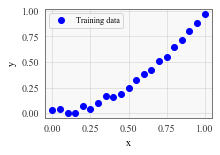

In [2]:
train_x = torch.linspace(0., 1., 21)
train_y = torch.pow(train_x, 2).mul_(3.7)
train_y = train_y.div_(train_y.max())
train_y += torch.randn_like(train_y).mul_(0.02)

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(train_x.numpy(), train_y.numpy(), 'bo')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(['Training data'])

## The PyroGP model

In order to use Pyro with GPyTorch, your model must inherit from `gpytorch.models.PyroGP` (rather than `gpytorch.modelks.ApproximateGP`). The `PyroGP` extends the `ApproximateGP` class and differs in a few key ways:

- It adds the `model` and  `guide` functions which are used by Pyro's inference engine.
- It's constructor requires two additional arguments beyond the variational strategy:
    - `likelihood` - the model's likelihood
    - `num_data` - the total amount of training data (required for minibatch SVI training)
    - `name_prefix` - a unique identifier for the model

In [3]:
class PVGPRegressionModel(gpytorch.models.PyroGP):
    def __init__(self, train_x, train_y, likelihood):
        # Define all the variational stuff
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=train_y.numel(),
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, train_x, variational_distribution
        )
        
        # Standard initializtation
        super(PVGPRegressionModel, self).__init__(
            variational_strategy,
            likelihood,
            num_data=train_y.numel(),
            name_prefix="simple_regression_model"
        )
        self.likelihood = likelihood
        
        # Mean, covar
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5)
        )

    def forward(self, x):
        mean = self.mean_module(x)  # Returns an n_data vec
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [4]:
model = PVGPRegressionModel(train_x, train_y, gpytorch.likelihoods.GaussianLikelihood())

## Performing inference with Pyro

Unlike all the other examples in this library, `PyroGP` models use Pyro's inference and optimization classes (rather than the classes provided by PyTorch).

If you are unfamiliar with Pyro's inference tools, we recommend checking out the [Pyro SVI tutorial](http://pyro.ai/examples/svi_part_i.html).

In [5]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
num_iter = 2 if smoke_test else 200
num_particles = 1 if smoke_test else 256


def train(lr=0.01):
    optimizer = pyro.optim.Adam({"lr": 0.1})
    elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
    svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)
    model.train()

    iterator = tqdm.notebook.tqdm(range(num_iter))
    for i in iterator:
        model.zero_grad()
        loss = svi.step(train_x, train_y)
        iterator.set_postfix(loss=loss)
        
%time train()


CPU times: user 17.7 s, sys: 460 ms, total: 18.2 s
Wall time: 2.75 s


In this example, we are only performing inference over the GP latent function (and its associated hyperparameters). In later examples, we will see that this basic loop also performs inference over any additional latent variables that we define.

## Making predictions

For some problems, we simply want to use Pyro to perform inference over latent variables. However, we can also use the models' (approximate) predictive posterior distribution. Making predictions with a PyroGP model is exactly the same as for standard GPyTorch models.

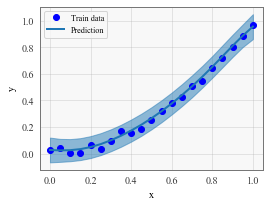

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
train_data, = ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'bo')

model.eval()
with torch.no_grad():
    output = model.likelihood(model(train_x))
    
mean = output.mean
lower, upper = output.confidence_region()
line, = ax.plot(train_x.cpu().numpy(), mean.detach().cpu().numpy())
ax.fill_between(train_x.cpu().numpy(), lower.detach().cpu().numpy(),
                upper.detach().cpu().numpy(), color=line.get_color(), alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend([train_data, line], ['Train data', 'Prediction'])

## Next steps

This was a pretty boring example, and it wasn't really all that different from GPyTorch's native SVGP implementation! The real power of the Pyro integration comes when we have additional latent variables to infer over. We will see an example of this in the [next example](./Clustered_Multitask_GP_Regression.ipynb), which learns a clustering over multiple time series using multitask GPs and Pyro.